In [52]:
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

import numpy as np
import pandas as pd

pd.set_option("display.max_columns", None)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid", palette="colorblind")
sns.set(rc={"figure.figsize": (11.5, 8.5), "figure.dpi": 100})

from sklearn import metrics
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels

from dataset import SCIData, SCICols
%load_ext autoreload
%autoreload 1
%aimport utils.data_profiling, dataset

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
#sci = SCIData.load('data/sci.h5').clean_all().filter_vague_diagnoses().derive_all().save()
sci = SCIData.load('data/sci_processed.h5')

## Critical Events

The NEWS specification prescribes the level of clinical response depending on the aggregate score the patient receives [RCP17, pp.53, 62]. 
 - Score 0: Low clinical risk, continue routine monitoring.
 - Score 1-4: Low clinical risk, ward-based response, RN assesment of patient.
 - Score of 3 in any single parameter: Low-medium risk, clinician review.
 - Score ≥ 5: Medium clinical risk, urgent response threshold, urgent clinician assessment.
 - Score ≥ 7: High clinical risk, emergency response threshold, urgent assessment, consider transfer to higher-dependency unit or ICU.

The original study measured ROCAUC based on whether patients that died within 24 hours triggered a red-level score [RCP12, pp. 15-16].
We consider "critical events" i.e. death during stay OR critical care admission.

In [32]:
sci['CriticalEvent'] = sci.DiedDuringStay | sci.CriticalCare
sci.CriticalEvent.sum()

10549

In [143]:
def plot_news_by_series(cols):
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
    for idx, (title, series) in enumerate(cols.items()):
        mask = sci.c_NEWS_score.notna() & series.notna()
        y_true, y_pred = \
            series[mask].astype(bool), sci[mask].c_NEWS_score
        metrics.RocCurveDisplay.from_predictions(y_true, y_pred, ax=ax[idx])
        ax[idx].set_title(title)

def plot_news_by_mask(masks, y_true_col = 'CriticalEvent'):
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
    for idx, (title, mask) in enumerate(masks.items()):
        mask = mask & sci.c_NEWS_score.notna()
        y_true, y_pred = \
            sci[mask][y_true_col], sci[mask].c_NEWS_score
        metrics.RocCurveDisplay.from_predictions(y_true, y_pred, ax=ax[idx])
        ax[idx].set_title(title)

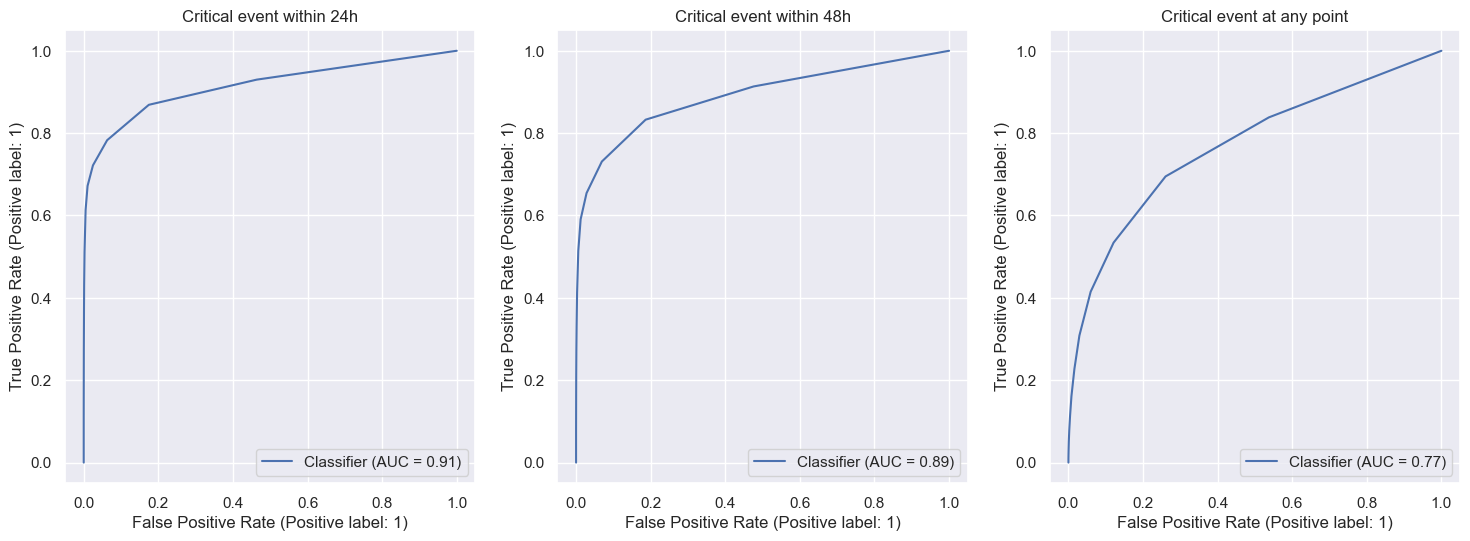

In [152]:
plot_news_by_mask({
    "Critical event within 24h": (sci.TotalLOS <= 1),
    "Critical event within 48h": (sci.TotalLOS <= 2),
    "Critical event at any point": True
})

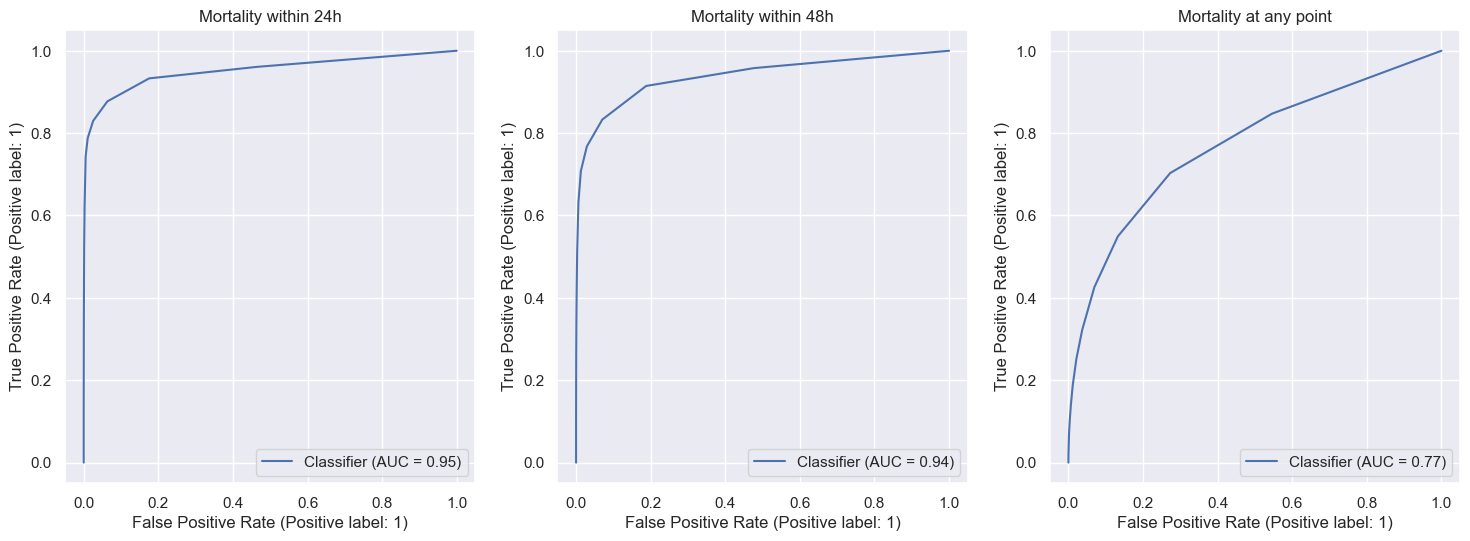

In [46]:
plot_news_by_mask({
    "Mortality within 24h": (sci.TotalLOS <= 1),
    "Mortality within 48h": (sci.TotalLOS <= 2),
    "Mortality at any point": True
}, "DiedDuringStay")

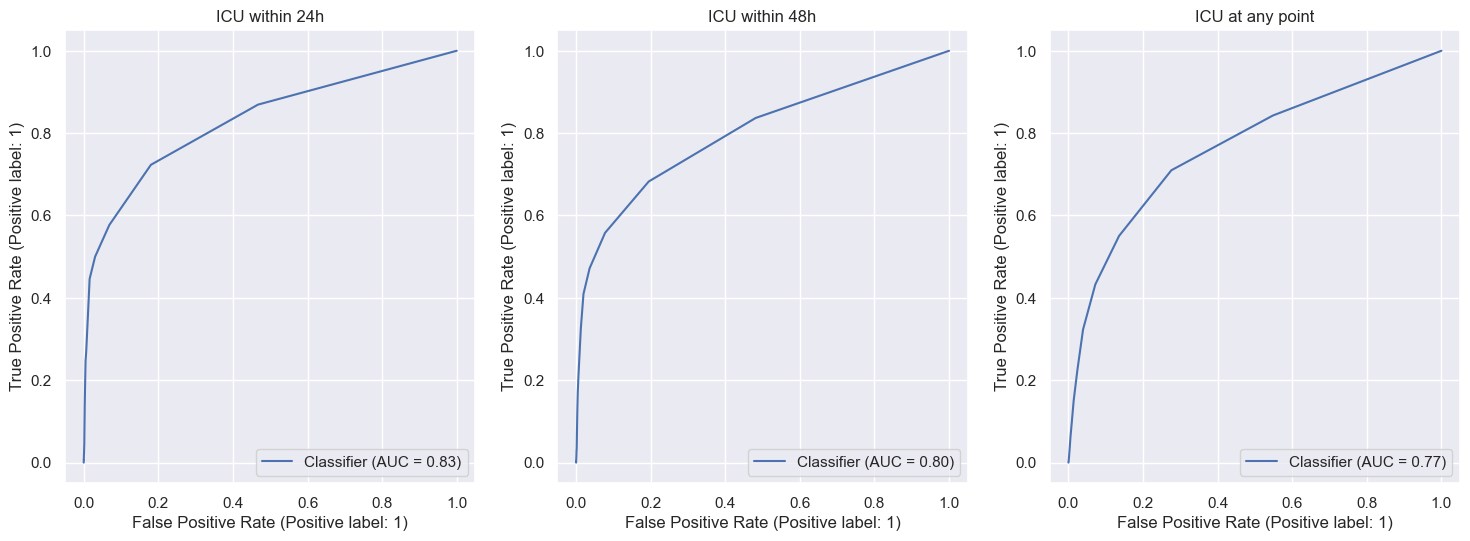

In [47]:
plot_news_by_mask({
    "ICU within 24h": (sci.TotalLOS <= 1),
    "ICU within 48h": (sci.TotalLOS <= 2),
    "ICU at any point": True
}, "CriticalCare")

## Readmission

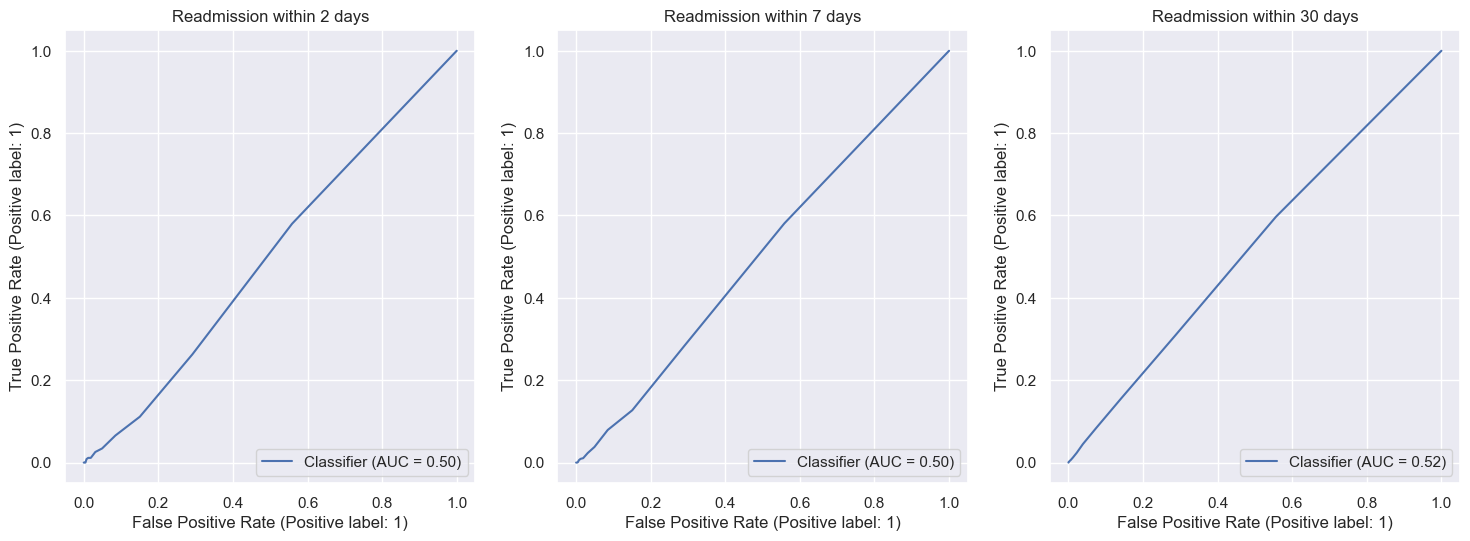

In [153]:
plot_news_by_series({
    "Readmission within 2 days": sci.Readmitted & (sci.ReadmissionTimespan <= pd.Timedelta(days=2)),
    "Readmission within 7 days": sci.Readmitted & (sci.ReadmissionTimespan <= pd.Timedelta(days=7)),
    "Readmission within 30 days": sci.Readmitted
})

## LOS

In [154]:
from scipy import stats

In [155]:
mask = (sci.TotalLOS > 0) * sci.c_NEWS_score.notna()
stats.spearmanr(sci[mask].c_NEWS_score, sci[mask].TotalLOS)

SpearmanrResult(correlation=0.2105968423291092, pvalue=0.0)

In [159]:
print(f'Median length of stay for scores under 7: {sci[(sci.c_NEWS_score < 7) & mask].TotalLOS.median()}')
print(f'Median length of stay for scores >= 7: {sci[(sci.c_NEWS_score >= 7) & mask].TotalLOS.median()}')


Median length of stay for scores under 7: 2.20625
Median length of stay for scores >= 7: 5.8972222
